In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
image_folder = r"C:\Users\DELL.COM\Desktop\Ephraim files\My CTR Data\Preprocessed"
mask_folder = r"C:\Users\DELL.COM\Desktop\Ephraim files\Generated_Masks"
model_save_path = r"C:\Users\DELL.COM\Desktop\Ephraim files\CTR_UNet_Model.h5"

# Load images and masks
def load_data(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])
    
    images = [tf.keras.utils.load_img(path, target_size=(512, 512), color_mode="grayscale") for path in image_paths]
    masks = [tf.keras.utils.load_img(path, target_size=(512, 512), color_mode="grayscale") for path in mask_paths]
    
    images = np.array([np.array(img) / 255.0 for img in images])  # Normalize
    masks = np.array([np.array(mask) / 255.0 for mask in masks])  # Normalize to 0-1
    return images[..., np.newaxis], masks[..., np.newaxis]  # Add channel dimension

# Load data
images, masks = load_data(image_folder, mask_folder)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,       # Randomly rotate images by 15 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (10% of total height)
    shear_range=0.1,         # Shear angle in counter-clockwise direction
    zoom_range=0.2,          # Randomly zoom images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode="nearest"      # Fill any empty pixels with the nearest values
)

# Data generator for augmented images and masks
def data_generator(image_data, mask_data, batch_size):
    seed = 42
    image_gen = datagen.flow(image_data, batch_size=batch_size, seed=seed)
    mask_gen = datagen.flow(mask_data, batch_size=batch_size, seed=seed)
    while True:
        yield next(image_gen), next(mask_gen)

# Build U-Net model
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])  # Concatenate encoder and decoder features
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])  # Concatenate encoder and decoder features
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)  # Single channel output
    model = models.Model(inputs, outputs)
    return model

# Compile model
model = build_unet((512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
batch_size = 8
steps_per_epoch = len(X_train) // batch_size

history = model.fit(
    data_generator(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    epochs=25
)

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate model
y_pred = model.predict(X_test)

# Threshold masks
def threshold_mask(mask, threshold=0.5):
    return (mask > threshold).astype(int)

y_pred_thresh = np.array([threshold_mask(pred) for pred in y_pred])

# Flatten arrays for metric calculations
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_thresh.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_flat, y_pred_flat)

# Display metrics
print("\nPerformance Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 16548s 221s/step - accuracy: 0.5543 - loss: 0.6238 - val_accuracy: 0.6418 - val_loss: 0.5443
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 17162s 222s/step - accuracy: 0.6484 - loss: 0.5273 - val_accuracy: 0.6078 - val_loss: 0.5944
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 17591s 229s/step - accuracy: 0.6798 - loss: 0.4917 - val_accuracy: 0.6962 - val_loss: 0.4979
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 18370s 242s/step - accuracy: 0.6958 - loss: 0.4709 - val_accuracy: 0.7561 - val_loss: 0.3884
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 19412s 255s/step - accuracy: 0.7445 - loss: 0.4124 - val_accuracy: 0.7945 - val_loss: 0.3212
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 17341s 228s/step - accuracy: 0.7499 - loss: 0.3918 - val_accuracy: 0.7962 - val_loss: 0.3218
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 17561s 233s/step - accuracy: 0.7807 - loss: 0.3381 - val_accuracy: 0.8034 - val_loss: 0.3035
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 16504s 215s/step - accuracy: 0.7927 - loss: 0

KeyboardInterrupt: 

: 

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
image_folder = r"C:\Users\DELL.COM\Desktop\Ephraim files\My CTR Data\Preprocessed"
mask_folder = r"C:\Users\DELL.COM\Desktop\Ephraim files\Generated_Masks"
model_save_path = r"C:\Users\DELL.COM\Desktop\Ephraim files\CTR_UNet_Model.keras"

# Load images and masks
def load_data(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])
    
    images = [tf.keras.utils.load_img(path, target_size=(256, 256), color_mode="grayscale") for path in image_paths]
    masks = [tf.keras.utils.load_img(path, target_size=(256, 256), color_mode="grayscale") for path in mask_paths]
    
    images = np.array([np.array(img) / 255.0 for img in images])  # Normalize
    masks = np.array([np.array(mask) / 255.0 for mask in masks])  # Normalize to 0-1
    return images[..., np.newaxis], masks[..., np.newaxis]  # Add channel dimension

# Load data
images, masks = load_data(image_folder, mask_folder)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

import tensorflow as tf
from tensorflow.keras import layers, models

# Build U-Net model
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    c2_resized = layers.Resizing(height=u6.shape[1], width=u6.shape[2])(c2)  # Resize to match u6
    u6 = layers.concatenate([u6, c2_resized])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c1_resized = layers.Resizing(height=u7.shape[1], width=u7.shape[2])(c1)  # Resize to match u7
    u7 = layers.concatenate([u7, c1_resized])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)  # Single-channel output
    model = models.Model(inputs, outputs)
    return model

# Compile model
model = build_unet((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to verify the structure
model.summary()


# Callback to save model after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
batch_size = 8
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=15,
    callbacks=[checkpoint]
)


# Evaluate model
y_pred = model.predict(X_test)

# Further evaluation and metrics calculation...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 128, 128,  │    131,200 │ conv2d_62[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 128, 128,  │          0 │ conv2d_60[0][0]   │
│ (Resizing)          │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ resizing_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │    295,040 │ concatenate_11[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_63[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 256, 256,  │     32,832 │ conv2d_64[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_3          │ (None, 256, 256,  │          0 │ conv2d_58[0][0]   │
│ (Resizing)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 256, 256,  │          0 │ conv2d_transpose

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2445s 32s/step - accuracy: 0.5871 - loss: 0.6200 - val_accuracy: 0.6656 - val_loss: 0.5230
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 4465s 58s/step - accuracy: 0.6941 - loss: 0.4866 - val_accuracy: 0.7353 - val_loss: 0.3955
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2397s 32s/step - accuracy: 0.7599 - loss: 0.3636 - val_accuracy: 0.7581 - val_loss: 0.3962
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2397s 32s/step - accuracy: 0.7810 - loss: 0.3326 - val_accuracy: 0.7919 - val_loss: 0.3130
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2431s 32s/step - accuracy: 0.8034 - loss: 0.2960 - val_accuracy: 0.8131 - val_loss: 0.2731
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2400s 32s/step - accuracy: 0.8099 - loss: 0.2787 - val_accuracy: 0.8184 - val_loss: 0.2594
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2846s 38s/step - accuracy: 0.8285 - loss: 0.2412 - val_accuracy: 0.8150 - val_loss: 0.2653
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2471s 32s/step - accuracy: 0.8258 - loss: 0.2418 - val_accu

Accuracy: 0.9215
Precision: 0.8179
Recall (Sensitivity): 0.9445
Specificity: 0.9118
F1 Score: 0.8767
ROC AUC: 0.9857


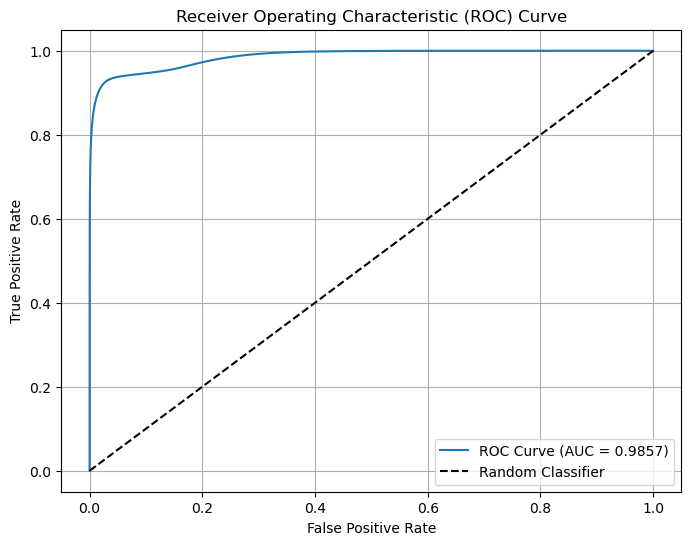

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions are binary by applying a threshold
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold predictions to 0 or 1

# Flatten predictions and ground truths for metric calculation
y_pred_flat = y_pred_binary.flatten()
y_test_flat = (y_test > 0.5).astype(int).flatten()  # Ensure ground truths are binary

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()

# Compute evaluation metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensitivity
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(y_test_flat, y_pred.flatten())  # Use continuous predictions for ROC AUC

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred.flatten())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()
